In [1]:
import monai
import pydicom
import pathlib
from glob import glob
import matplotlib.pyplot as plt
# import pyxnat
import torch
import xnat

# Get the bundle name

In [15]:
bundles_list = monai.bundle.get_all_bundles_list()
name, date = next((n, d) for n, d in bundles_list if 'lung' in n)

# Download the bundle
```python
python -m monai.bundle download --name spleen_ct_segmentation --bundle_dir "./"
```

In [17]:
import pathlib
bundle_dir = pathlib.Path('../../bundles').resolve()
bundle_dir.mkdir(exist_ok=True)

monai.bundle.download(name=name, bundle_dir=bundle_dir)

2023-06-07 18:23:55,769 - INFO - --- input summary of monai.bundle.scripts.download ---
2023-06-07 18:23:55,769 - INFO - > name: 'lung_nodule_ct_detection'
2023-06-07 18:23:55,769 - INFO - > bundle_dir: PosixPath('/Users/personal-macbook/Documents/GitHubs/Data7/bundles')
2023-06-07 18:23:55,770 - INFO - > source: 'github'
2023-06-07 18:23:55,771 - INFO - > remove_prefix: 'monai_'
2023-06-07 18:23:55,771 - INFO - > progress: True
2023-06-07 18:23:55,773 - INFO - ---




lung_nodule_ct_detection_v0.5.8.zip: 148MB [00:07, 19.7MB/s]                              

2023-06-07 18:24:04,226 - INFO - Downloaded: /Users/personal-macbook/Documents/GitHubs/Data7/bundles/lung_nodule_ct_detection_v0.5.8.zip
2023-06-07 18:24:04,227 - INFO - Expected md5 is None, skip md5 check for file /Users/personal-macbook/Documents/GitHubs/Data7/bundles/lung_nodule_ct_detection_v0.5.8.zip.
2023-06-07 18:24:04,227 - INFO - Writing into directory: /Users/personal-macbook/Documents/GitHubs/Data7/bundles.


In [21]:
model_weights = monai.bundle.load(name=name, bundle_dir=bundle_dir)

In [30]:
# use pretrained Lung Nodule model in monai package

from monai.apps.utils import download_and_extract
from monai.networks.nets.densenet import DenseNet121


monai.apps.detection()

# model = DenseNet121(spatial_dims=3, in_channels=1, out_channels=3)
# model.load_state_dict(torch.load("/path/to/downloaded/model/model.pt"))

TypeError: 'module' object is not callable

In [13]:
import monai
from monai.networks.nets.densenet import DenseNet121

model_name = "lung_nodule_detection_3d_ct"
model_hash = "fb8dbe001f55a03ed0d2c9d5b31dde8782f79669"

model = DenseNet121(
    pretrained=True,
    progress=True,
    model_name=model_name,
    model_hash=model_hash
)

TypeError: DenseNet.__init__() got an unexpected keyword argument 'model_name'

# Connecting to XNAT's REST API 

In [2]:
mode = 'local_machine'
server_dict = dict(local_machine='http://localhost:80' , inside_xnat='http://xnat-web:8080')
interface = pyxnat.Interface(server=server_dict[mode], user='admin', password='admin')

# Level 1. Project

In [3]:
print('list of projects:', interface.select.projects().get())

list of projects: ['project', 'demo1']


In [4]:
project_ID = 'demo1'
project = interface.select.project(project_ID)


print('list of users:', project.users())
print('list of subjects:', project.subjects().get())
print('list of experiments:', project.experiments().get())
print('list of resources:', project.resources().get())

list of users: ['admin', 'xnat', 'artin']
list of subjects: ['XNAT_S00004', 'XNAT_S00005', 'XNAT_S00006', 'XNAT_S00007']
list of experiments: ['XNAT_E00004', 'XNAT_E00005', 'XNAT_E00006', 'XNAT_E00007']
list of resources: []


# Level 2. Subject

In [5]:
ix = 0
subject_ID = project.subjects().get()[ix]
print('subject_ID:', subject_ID)

subject = project.subject(subject_ID)
subject

subject_ID: XNAT_S00004


<Subject Object> XNAT_S00004 `10000019` (project: demo1) (Gender: U) 1 experiment http://localhost:80/data/projects/demo1/subjects/XNAT_S00004?format=html

# Level 3. Experiments

### Setting the experiment

In [6]:
experiment_ID = project.experiments().get()[ix]
print('experiment_ID:', experiment_ID)

experiment = subject.experiment(experiment_ID)
experiment

experiment_ID: XNAT_E00004


<Experiment Object> XNAT_E00004 `16900004` (subject: XNAT_S00004 `10000019`) (project: demo1) 4 scans 0 resource (created on 2023-05-20 09:40:47.239) http://localhost:80/data/projects/demo1/subjects/XNAT_S00004/experiments/XNAT_E00004?format=html

### Creating a new experiment

In [7]:
# experiment.create(experiments='xnat:ctSessionData')

# experiment.attrs.mset({
#     'xnat:mrSessionData/coil' : 'head',
#     'xnat:mrSessionData/marker' : 'right',
# })

# Level 4. Scans

### List of scans in the experiment

In [8]:
print('scans:', experiment.scans().get() )

scans: ['2', '4', '5', '6']


In [9]:
i_s = 0
scan_ID = experiment.scans().get()[i_s]
print('scan_ID:', scan_ID)

scan = experiment.scan(scan_ID)
scan

scan_ID: 2


<Scan Object> 2 (`AXIAL` 258 frames) usable http://localhost:80/data/projects/demo1/subjects/XNAT_S00004/experiments/XNAT_E00004/scans/2?format=html

In [10]:
scan.children()

['resources']

In [11]:
# # List all resources for the scan
# for resource in scan.resources().fetchall():
#     print(resource)
#     # print(resource.id(), resource.label(), resource.datatype())

# scan.resource('9').get()

### Creating a New Scan

In [12]:
# scan.create(scans='xnat:ctScanData')

# # Setting scan attributes
# scan.attrs.mset({
#     'xnat:ctScanData/parameters/imageType' : 'dicom',
#     'xnat:ctScanData/series_description': 'something'
# })

# Adding DICOM files to a scan
# dicom_resource = scan.resource('DICOM')
# dicom_resource.put_dir()

# Level 5. Resources

In [13]:
resource = scan.resource('DICOM')

In [14]:
files =  resource.files()
attributes = files[0].attributes()
attributes

{'Name': '1947292648.CT.20191029.132403.2.150.unknown.dcm',
 'Size': '207682',
 'URI': '/data/projects/demo1/subjects/XNAT_S00004/experiments/XNAT_E00004/scans/2/resources/9/files/1947292648.CT.20191029.132403.2.150.unknown.dcm',
 'file_tags': '',
 'file_format': 'DICOM',
 'file_content': '',
 'path': '1947292648.CT.20191029.132403.2.150.unknown.dcm'}

In [15]:
URI = pathlib.Path(attributes['URI'])
URI

PosixPath('/data/projects/demo1/subjects/XNAT_S00004/experiments/XNAT_E00004/scans/2/resources/9/files/1947292648.CT.20191029.132403.2.150.unknown.dcm')

In [16]:
# content = interface.get(uri=URI).content.decode()
# content

In [17]:
# subject_id = 'your-subject-id'
# session_id = 'your-session-id'
# dicom_files = xnat.select('/projects/your-project-id/subjects/{}/experiments/{}/scans/*/resources/DICOM/files'.format(subject_id, session_id))

In [18]:
# Downloading the whole resource (consists of multiple dicom files in the scan)
local_machine_dir = pathlib.Path('.')
path_list = resource.get(dest_dir=local_machine_dir, extract=True)
path_list[:5]

['./DICOM/1947292648.CT.20191029.132403.2.150.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.151.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.152.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.59.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.58.unknown.dcm']

# Visualization

In [19]:
!pip install GDCM pylibjpeg pylibjpeg-libjpeg

In [20]:
path = path_list[0]
dcm_file = pydicom.dcmread(path)
dcm_file.pixel_array

array([[-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       ...,
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024]], dtype=int16)

# Visualize the dicom image

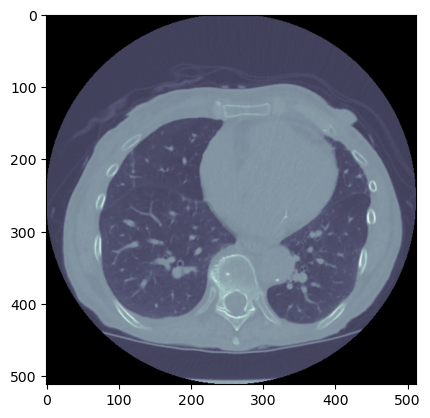

In [21]:
fig = plt.figure()
plt.imshow(dcm_file.pixel_array, cmap=plt.cm.bone)

## Applying transformations using monai library

In [22]:
im = dcm_file.pixel_array 

from monai.transforms import AdjustContrast
adjuster = AdjustContrast(.02)
im2 = adjuster(im)
# plt.imshow(im2, cmap=plt.cm.bone)

ModuleNotFoundError: No module named 'monai'

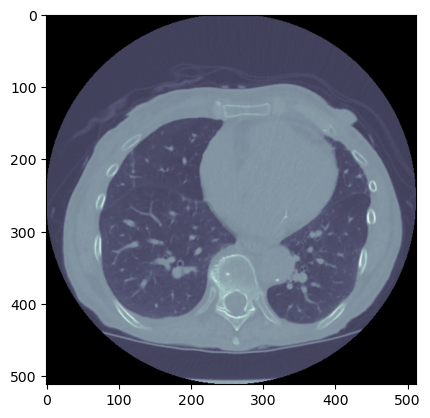

In [ ]:
dataset = pydicom.Dataset(pixel_array=im2) 
dcm_file.update(dataset)
plt.imshow(dcm_file.pixel_array, cmap=plt.cm.bone)

In [23]:
new_name = URI.stem + '_adjusted' + URI.suffix
print('new_name' , new_name)

out_dir = local_machine_dir.joinpath(new_name)
print('out_dir',out_dir)

pydicom.dcmwrite(out_dir, dcm_file)

list(local_machine_dir.glob('*.dcm'))

new_name 1947292648.CT.20191029.132403.2.150.unknown_adjusted.dcm
out_dir 1947292648.CT.20191029.132403.2.150.unknown_adjusted.dcm


[PosixPath('1947292648.CT.20191029.132403.2.150.unknown_adjusted.dcm')]

In [24]:
resource = interface.select.project(project_ID).subject(subject_ID).experiment(experiment_ID).scan(scan_ID).resource('DICOM')
# file1 = resource.file(URI.name)
# file1.get('temp.dcm')

resource.file(ID=new_name).insert(out_dir)
# resource.file(ID=new_name).put(out_dir)

In [25]:
# interface.select.project(project_ID).subject(subject_ID).experiment(experiment_ID).resource('DICOM').files

In [26]:
resource.get(dest_dir=local_machine_dir, extract=True)

['./DICOM/1947292648.CT.20191029.132403.2.150.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.151.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.152.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.59.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.58.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.57.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.55.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.54.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.56.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.51.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.62.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.50.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.52.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.61.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.63.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.53.unknown.dcm',
 './DICOM/1947292648.CT.20191029.132403.2.60.unknown.